# Models and Machine Learning

The data has been wrangled and thoroughly examined -- now to see if it can be generalized to new data.

## Load in the data and packages

In [1]:
# Import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

In [3]:
# See data wrangling report for more details
#load data
spotify = pd.read_csv('../Data/SpotifyFeatures0419.csv')

# Create the sorted dataframe and drop zeros
sort_data = spotify.sort_values('popularity', ascending=False).reset_index()
spotify_ordered = sort_data.drop(['index', 'track_id'], axis=1)
spotify_ordered.index = spotify_ordered.index + 1
spotify_ordered = spotify_ordered[spotify_ordered.popularity > 0]
spotify_ordered[['mode', 'key', 'time_signature']] = \
    spotify_ordered[['mode', 'key', 'time_signature']].astype('category')

In [4]:
#Create table with a column classifying popularity ratings
classified = spotify_ordered.copy()
classified['pop_rating'] = ''

for i, row in classified.iterrows():
    score = 'unpopular'
    if (row.popularity > 50) & (row.popularity < 75):
        score = 'medium'
    elif row.popularity >= 75:
        score = 'popular'
    classified.at[i, 'pop_rating'] = score

## Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Set random state
state=25

# Shuffle the data
reg_data = spotify_ordered.sample(frac=1, random_state=state).reset_index(drop=True)

# First, try without categoricals
X = reg_data.select_dtypes(include='number').drop('popularity', axis=1)
y = reg_data.popularity

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=state)

The data has been split into train and test sets, let's see the result out of the box.

In [9]:
# Set the regressor
lr = LinearRegression()

# Fit the train data
lr.fit(X_train, y_train)

# Check the R^2 score
lr.score(X_test, y_test)

0.09837878124451926

The score out of the box is not spectacular. Before delving into the model itself, let's try and improve the data.<br>
<br>
First, we can see what happens when using the categoricals by using one hot encoding with .get_dummies(). For this step, I have decided to drop the artist_name column. While song popularity is often correlated with artist popularity, the hope is for this model to work just as well on an artist it hasn't seen before. Part of the goal is to be able to discover new talent, and that becomes more difficult if the algorithm is inclined to discredit a song just because it doesn't recognize the artist. Therefore, the column will be dropped for training purposes.

In [18]:
no_artist = reg_data.drop(['artist_name', 'track_name'], axis=1)
df_encoded = pd.get_dummies(no_artist)
df_encoded.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'popularity', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'mode_0', 'mode_1', 'time_signature_0', 'time_signature_1',
       'time_signature_3', 'time_signature_4', 'time_signature_5'],
      dtype='object')

In [22]:
# Do a new split and run a new linear model
XX = df_encoded.drop('popularity', axis=1)
yy = df_encoded.popularity

X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.25, random_state=state)

lr_cat = LinearRegression()
lr_cat.fit(X_train, y_train)

print(lr_cat.score(X_test, y_test))

0.09995186109823984


The result is better, but only marginally. To help ensure this result is accurate, cross-validation can be used.

In [27]:
from sklearn.model_selection import cross_val_score

# Use the regressor from above to set up the cross_val
cvals = cross_val_score(lr_cat, XX, yy, cv=6)

# check the results
print(cvals)
print('The mean cross-validatoin score is: {num:.{dig}f}'.format\
      (num=np.mean(cvals), dig=4))

[0.10283964 0.1004429  0.09977221 0.094989   0.1048918  0.09949721]
The mean cross-validatoin score is: 0.1004


The results are fairly similar across all of the folds, and the mean score is about the same as all of the previous results. <br>
<br>
This seems to indicate that plain linear regression isn't well suited for this problem, which isn't surprising. Let's try to improve on it using ridge regression.

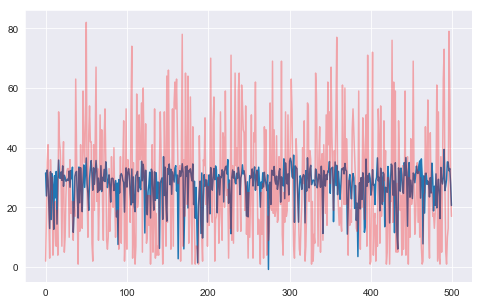

In [15]:
fig = plt.subplots(figsize=(8,5))
_ = plt.plot(list(lr_pred)[:500])
_ = plt.plot(list(y_test)[:500], c='r', alpha=0.3)